deployments

In [228]:
import pandas as pd
df = pd.read_csv('../deployments/governor/governor_deployments.csv')
df.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,46
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0


In [229]:
import uuid
df['id_to_hash'] = df.apply(lambda row: row['platform'] + '_' + str(row['platform_id']), axis=1)
df['id'] = df.apply(lambda row: str(uuid.uuid5(uuid.NAMESPACE_OID, row['id_to_hash'])), axis=1)
df.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,id_to_hash,id
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0,governor_00233765-eb17-4e75-954f-82258bb990aa,76de652b-10a7-5328-b1e9-ca0787c4c800
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0,governor_0032e64d-5105-4369-89c4-46f05247c684,930b87ef-5d55-59bb-ae88-b7e59941a55a
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,46,governor_00453db4-685a-4221-9ad1-fda0d82c3a8a,777c6d22-8b0d-5f44-9a08-ed7876acf450
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0,governor_004556b2-f0c0-4843-887c-4b539140ee43,e08550d2-3d2d-563b-8ce8-544b9efab8c9
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0,governor_0050d8cf-2650-4d66-94dc-77d871b0d755,3fe57dec-e937-5e62-b7b4-1aedd4b45bad


In [230]:
# use duckdb, read ../parquets_version4/proposals.parquet and ../parquets_version4/votes.parquet into views
import duckdb

con = duckdb.connect(database=':memory:', read_only=False)
con.execute("CREATE VIEW proposals AS SELECT * FROM read_parquet('../parquets_version5/proposals.parquet')")
con.execute("CREATE VIEW votes AS SELECT * FROM read_parquet('../parquets_version5/votes.parquet')")

# count the proposals and the votes and group on deployment_id
query = """
SELECT
    deployment_id as id,
    COUNT(*) as new_proposals_count,
FROM
    proposals
GROUP BY
    deployment_id
"""
df_to_merge = con.execute(query).fetch_df()
df_to_merge

,id,new_proposals_count
0,eb02e21a-daf5-527f-a215-fe1ea3930fce,98
1,df706770-3a01-56e4-a844-e367879da1d7,16
2,ecb59e9f-7ae4-5315-bc5d-9ee0ca3462c8,126
3,81b5712f-f254-50dc-bae6-39fa8d81765a,1
4,78e803f1-40ac-5d1a-8fbd-639dfb9e5994,6
...,...,...
19893,556b086f-a826-5e22-abe2-e52fd22f9a0e,1
19894,5d9cd91f-920b-5768-b809-8373599fdc82,1
19895,e5c9f4d1-6d39-51b3-975b-3e0b7fc6349d,1
19896,3f00d3fb-bfcf-5e3c-acbc-e8b68e680297,1


In [231]:
query = """
SELECT
    deployment_id as id,
    COUNT(*) as new_votes_count,
FROM
    votes
GROUP BY
    deployment_id
"""
votes_to_merge = con.execute(query).fetch_df()
votes_to_merge

,id,new_votes_count
0,866f25de-a897-515f-ab17-c9ed518616ab,1639
1,6edb55f0-bd4e-5f66-bbd0-5bd2573429ff,220
2,195dff68-95c4-5ab3-9f26-6bf7beb9c67a,9355
3,b9fe8b04-17b0-5819-8148-1fcf146966d5,8881
4,9d550003-ea37-5c87-af9a-8d1c4a59809c,1716
...,...,...
16758,75d3596a-c319-5330-bb57-1c36926774f4,48
16759,a2660833-2901-5c24-83e1-89c56403bd23,2
16760,6e73a997-be5e-53b1-a9ed-ef0fec2ccac4,5
16761,b24ebb37-8981-5da7-a4ba-f4d6bd031b0c,4


In [232]:
# merge with df
df = df.merge(df_to_merge, on='id', how='left', validate='1:1')
df = df.merge(votes_to_merge, on='id', how='left', validate='1:1')
df.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,id_to_hash,id,new_proposals_count,new_votes_count
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0,governor_00233765-eb17-4e75-954f-82258bb990aa,76de652b-10a7-5328-b1e9-ca0787c4c800,NaN,NaN
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0,governor_0032e64d-5105-4369-89c4-46f05247c684,930b87ef-5d55-59bb-ae88-b7e59941a55a,NaN,NaN
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,46,governor_00453db4-685a-4221-9ad1-fda0d82c3a8a,777c6d22-8b0d-5f44-9a08-ed7876acf450,NaN,NaN
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0,governor_004556b2-f0c0-4843-887c-4b539140ee43,e08550d2-3d2d-563b-8ce8-544b9efab8c9,NaN,NaN
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0,governor_0050d8cf-2650-4d66-94dc-77d871b0d755,3fe57dec-e937-5e62-b7b4-1aedd4b45bad,NaN,NaN


In [233]:
# describe new_proposals_count
df.new_proposals_count.describe()

count     21.000000
mean      35.238095
std       48.113309
min        4.000000
25%        9.000000
50%       15.000000
75%       36.000000
max      173.000000
Name: new_proposals_count, dtype: float64

In [234]:
df.new_votes_count.describe()

count        21.000000
mean      19653.047619
std       75765.388165
min          18.000000
25%          59.000000
50%         296.000000
75%        2964.000000
max      349082.000000
Name: new_votes_count, dtype: float64

<Axes: xlabel='votes_count', ylabel='new_votes_count'>

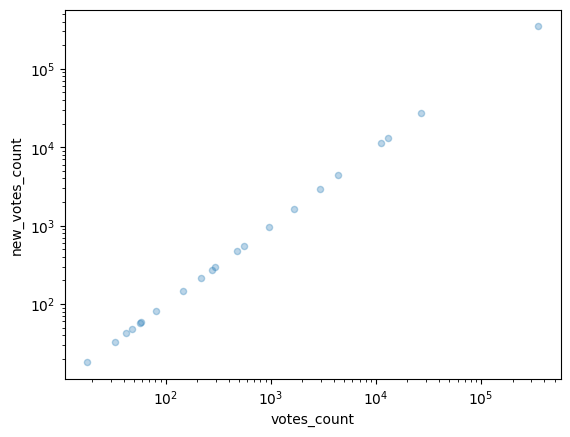

In [235]:
df.plot.scatter(x='votes_count', y='new_votes_count', loglog=True, alpha=0.30)

In [236]:
df['votes_count'].corr(df['new_votes_count'])

0.9999999999999998

In [237]:
# how many have a votes_count value but no new_votes_count value?
df[(df['votes_count'] > 0) & (df['new_votes_count'].isnull())].shape

(0, 11)

<Axes: xlabel='proposals_count', ylabel='new_proposals_count'>

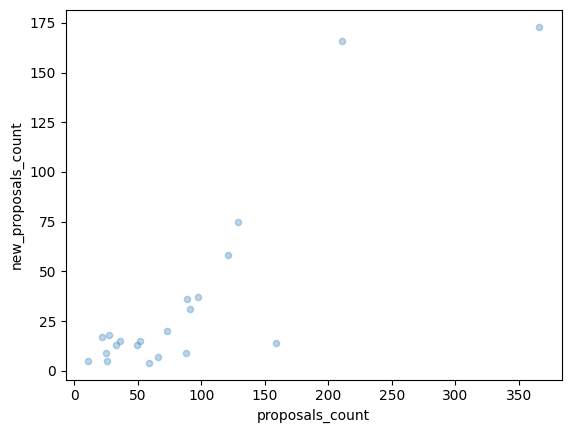

In [238]:
df.plot.scatter(x='proposals_count', y='new_proposals_count', alpha=0.30)

In [239]:
df['proposals_count'].corr(df['new_proposals_count'])
# this is because we only count proposals on the governor platform, while the platform in
# their summary stats also includes proposals that take in other places, i.e., on forums
# or on snapshot

0.8818853409387047

In [240]:
df[df['proposals_count'] > 0].shape

(140, 11)

In [241]:
df[df['new_proposals_count'] > 0].shape

(21, 11)

In [242]:
df[(df['proposals_count'] > 0) & (df['new_proposals_count'].isnull())].shape

(119, 11)

In [243]:
df.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,id_to_hash,id,new_proposals_count,new_votes_count
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0,governor_00233765-eb17-4e75-954f-82258bb990aa,76de652b-10a7-5328-b1e9-ca0787c4c800,NaN,NaN
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0,governor_0032e64d-5105-4369-89c4-46f05247c684,930b87ef-5d55-59bb-ae88-b7e59941a55a,NaN,NaN
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,46,governor_00453db4-685a-4221-9ad1-fda0d82c3a8a,777c6d22-8b0d-5f44-9a08-ed7876acf450,NaN,NaN
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0,governor_004556b2-f0c0-4843-887c-4b539140ee43,e08550d2-3d2d-563b-8ce8-544b9efab8c9,NaN,NaN
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0,governor_0050d8cf-2650-4d66-94dc-77d871b0d755,3fe57dec-e937-5e62-b7b4-1aedd4b45bad,NaN,NaN


In [244]:
# fill new_proposals_count and new_votes_count nas with 0
df.fillna({'new_proposals_count': 0, 'new_votes_count': 0}, inplace=True)
# make both cols int
df = df.astype({'new_proposals_count': 'int', 'new_votes_count': 'int'})
df.head()

,platform,platform_id,name,website,additional,votes_count,proposals_count,id_to_hash,id,new_proposals_count,new_votes_count
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0,governor_00233765-eb17-4e75-954f-82258bb990aa,76de652b-10a7-5328-b1e9-ca0787c4c800,0,0
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0,governor_0032e64d-5105-4369-89c4-46f05247c684,930b87ef-5d55-59bb-ae88-b7e59941a55a,0,0
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,46,governor_00453db4-685a-4221-9ad1-fda0d82c3a8a,777c6d22-8b0d-5f44-9a08-ed7876acf450,0,0
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0,governor_004556b2-f0c0-4843-887c-4b539140ee43,e08550d2-3d2d-563b-8ce8-544b9efab8c9,0,0
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0,governor_0050d8cf-2650-4d66-94dc-77d871b0d755,3fe57dec-e937-5e62-b7b4-1aedd4b45bad,0,0


In [245]:
df.drop(['proposals_count', 'votes_count'], inplace=True, axis=1)

In [246]:
# rename new_proposals_count and new_votes_count to new_proposals and new_votes
df = df.rename(columns={'new_proposals_count': 'proposals_count', 'new_votes_count': 'votes_count', 'platform_id': 'platform_deployment_id'})
df.head()

,platform,platform_deployment_id,name,website,additional,id_to_hash,id,proposals_count,votes_count
0,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,governor_00233765-eb17-4e75-954f-82258bb990aa,76de652b-10a7-5328-b1e9-ca0787c4c800,0,0
1,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,governor_0032e64d-5105-4369-89c4-46f05247c684,930b87ef-5d55-59bb-ae88-b7e59941a55a,0,0
2,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,governor_00453db4-685a-4221-9ad1-fda0d82c3a8a,777c6d22-8b0d-5f44-9a08-ed7876acf450,0,0
3,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,governor_004556b2-f0c0-4843-887c-4b539140ee43,e08550d2-3d2d-563b-8ce8-544b9efab8c9,0,0
4,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,governor_0050d8cf-2650-4d66-94dc-77d871b0d755,3fe57dec-e937-5e62-b7b4-1aedd4b45bad,0,0


In [247]:
df = df[[
    'id',
    'platform',
    'platform_deployment_id',
    'name',
    'website',
    'additional',
    'votes_count',
    'proposals_count',
]]
df.head()

,id,platform,platform_deployment_id,name,website,additional,votes_count,proposals_count
0,76de652b-10a7-5328-b1e9-ca0787c4c800,governor,00233765-eb17-4e75-954f-82258bb990aa,Shell Protocol,NaN,NaN,0,0
1,930b87ef-5d55-59bb-ae88-b7e59941a55a,governor,0032e64d-5105-4369-89c4-46f05247c684,Free Company,NaN,NaN,0,0
2,777c6d22-8b0d-5f44-9a08-ed7876acf450,governor,00453db4-685a-4221-9ad1-fda0d82c3a8a,Cream Finance,NaN,NaN,0,0
3,e08550d2-3d2d-563b-8ce8-544b9efab8c9,governor,004556b2-f0c0-4843-887c-4b539140ee43,Bleeps DAO,NaN,NaN,0,0
4,3fe57dec-e937-5e62-b7b4-1aedd4b45bad,governor,0050d8cf-2650-4d66-94dc-77d871b0d755,Psychedelic,NaN,NaN,0,0


In [248]:
import pyarrow.parquet as pq

# Read in the parquet file from v4, then we'll write to v5
deployments = pq.read_table('../parquets_version4/deployments.parquet')
deployments.schema

id: string
platform: string
platform_deployment_id: string
name: string
website: string
additional: string
votes_count: int64
proposals_count: int64
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1215

In [249]:
import pyarrow as pa
# make website type a string
df['website'] = df['website'].astype(str)
# make additional type a string
df['additional'] = df['additional'].astype(str)
governor_deployments_table = pa.Table.from_pandas(df, preserve_index=False)
governor_deployments_table

pyarrow.Table
id: string
platform: string
platform_deployment_id: string
name: string
website: string
additional: string
votes_count: int64
proposals_count: int64
----
id: [["76de652b-10a7-5328-b1e9-ca0787c4c800","930b87ef-5d55-59bb-ae88-b7e59941a55a","777c6d22-8b0d-5f44-9a08-ed7876acf450","e08550d2-3d2d-563b-8ce8-544b9efab8c9","3fe57dec-e937-5e62-b7b4-1aedd4b45bad",...,"7b092524-457f-5ec5-8a1d-6a7f2b43841d","34d64844-9aac-5420-95c1-43f0d9d42a9b","dd528f1a-b1bb-5db0-a7dc-d19f0cd2fdd2","df84acc2-b7e0-5a8d-8e0a-5dcaf9f118fb","42d786cd-3bfe-560d-88cb-680b81c5c60d"]]
platform: [["governor","governor","governor","governor","governor",...,"governor","governor","governor","governor","governor"]]
platform_deployment_id: [["00233765-eb17-4e75-954f-82258bb990aa","0032e64d-5105-4369-89c4-46f05247c684","00453db4-685a-4221-9ad1-fda0d82c3a8a","004556b2-f0c0-4843-887c-4b539140ee43","0050d8cf-2650-4d66-94dc-77d871b0d755",...,"fe5f7e1a-67b9-4203-84bc-4b909280fbae","fe72217c-ae9a-4cbd-9921-fc67592e05ce"

In [250]:
import pyarrow.parquet as pq
import pyarrow as pa
from pyarrow.parquet import ParquetFile
deployments_v4_pf = ParquetFile('../parquets_version4/deployments.parquet')
for i, record_batch in enumerate(deployments_v4_pf.iter_batches(batch_size=10000)):
    # for the first chunk of records
    table = pa.Table.from_batches([record_batch])
    if i == 0:
        # create a parquet write object giving it an output file
        pqwriter = pq.ParquetWriter('../parquets_version5/deployments.parquet', table.schema)            
    pqwriter.write_table(table)

pqwriter.write_table(governor_deployments_table)

# close the parquet writer
pqwriter.close()

In [251]:
# read '../parquets_version4/deployments.parquet' size without opening
with pq.ParquetFile('../parquets_version4/deployments.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
    print(f'Number of rows: {num_rows}')
    print(f'Number of columns: {num_columns}')

Number of rows: 30128
Number of columns: 8


In [252]:
# read '../parquets_version5/deployments.parquet' size without opening
with pq.ParquetFile('../parquets_version5/deployments.parquet') as pf:
    num_rows = pf.metadata.num_rows
    num_columns = len(pf.metadata.schema.names)
    print(f'Number of rows: {num_rows}')
    print(f'Number of columns: {num_columns}')

Number of rows: 31013
Number of columns: 8
